<h3>  Imports </h3>

In [24]:
import numpy as np
import time
import matplotlib.cm as cm 
import matplotlib.pyplot as plt

# Fetching datasets 

In [25]:
datasets_path = "/Users/31_grudnia/Desktop/Python/Playground/Masters_Degree_Project/backend/MNIST_app/MNIST_utils_files/signs_with_labels/"

# Train datasets
X_train: np.ndarray = np.load(datasets_path + "X_train.npy")
Y_train: np.ndarray = np.load(datasets_path + "Y_train.npy")

In [26]:
# Test datasets
X_test: np.ndarray = np.load(datasets_path + "X_test.npy")
Y_test: np.ndarray = np.load(datasets_path + "Y_test.npy")

In [27]:
# Validation datasets
X_val: np.ndarray = np.load(datasets_path + "X_val.npy")
Y_val: np.ndarray = np.load(datasets_path + "Y_val.npy")

In [28]:
X_train, X_test, X_val = X_train / 255., X_test / 255., X_val / 255.

# One Hot Encoder

In [29]:
def one_hot_encode(Y_data: np.ndarray) -> np.ndarray:
    
    Y_ohe: np.ndarray = Y_data.copy()
    categories: np.ndarray = sorted(list(set(Y_ohe)))
    one_hot_encoded_data: np.ndarray = []
    
    for index in range(len(Y_ohe)):
        row: np.ndarray = np.zeros(shape=(len(categories), ), dtype=int)
        row[Y_ohe[index]] = 1
        # print(f"Element {Y_ohe[index]} - for row {row}")
        one_hot_encoded_data.append(row)
    
    one_hot_encoded_data = np.array(one_hot_encoded_data)
    return one_hot_encoded_data

In [30]:
Y_train_ohe: np.ndarray = one_hot_encode(Y_data=Y_train)
Y_test_ohe: np.ndarray = one_hot_encode(Y_data=Y_test)

# Optimizers

In [31]:
class Optimizers:
    
    @staticmethod
    def SGD(w, dw, alpha=0.01, beta=0.09):
        w = w - alpha * dw
        return w

# Loss Functions

In [32]:
class LossFunctions:
    
    @staticmethod
    def Categorical_Crossentropy(y_pred, y_true):
        return -np.mean(np.sum(y_true * np.log(y_pred), axis=1))


# Activation Functions

In [33]:
class Activations:
    
    @staticmethod
    def relu(x):
        return np.maximum(0, x)
    
    @staticmethod
    def softmax(x):
        exp_x = np.exp(x - np.max(x))  # Subtracting the maximum value for numerical stability
        return exp_x / exp_x.sum(axis=0)

# Layers
- Dense
    - Init of parameters (bias and weights)
    - Forward Propagation
    - Backward Propagation
    - Dropout

In [34]:
class Layers:
    class Dense:
        
        def __init__(self, neurons=0, activation=Activations.relu, inputs=0, dropout_rate=1):
            # Initialization of weights and biases
            self.weights = np.random.randn(neurons, inputs)
            self.biases = np.random.randn(1, neurons)
            self.activation = activation
            self.dropout_rate = dropout_rate
        
        def forward(self, inputs):
            self.inputs = inputs
            self.outputs = np.dot(inputs, self.weights.T) + self.biases
            self.outputs = self.activation(self.outputs)
            self.outputs = self.dropout(self.outputs)
            return self.outputs
        
        def backward(self, error, learning_rate):
            self.error = error
            self.delta = self.error * self.activation(self.outputs, derivative=True)
            self.delta = self.dropout(self.delta, derivative=True)
            self.weights -= learning_rate * np.dot(self.delta, self.inputs.T)
            self.biases -= learning_rate * np.sum(self.delta, axis=0, keepdims=True)
            return self.delta
        
        def dropout(self, x, derivative=False):
            if derivative:
                return self.dropout_rate * (1 - self.dropout_rate) * x
            return self.dropout_rate * x 


# Neural Network

In [35]:
class NeuralNetwork:
    
    def __init__(self, layers, loss=LossFunctions.Categorical_Crossentropy, optimizer=Optimizers.SGD, learning_rate=0.01, momentum=0.0, beta1=0.9, beta2=0.999, epsilon=1e-7):
        self.layers = layers
        self.loss = loss
        self.optimizer = optimizer
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.weights = []
        self.biases = []
        self.velocities = []
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.optimizer_kwargs = {'alpha': self.learning_rate, 'beta1': self.beta1, 'beta2': self.beta2}
        if self.optimizer == Optimizers.SGD:
            self.optimizer_kwargs['momentum'] = self.momentum
        
    def forward(self, inputs):
        self.inputs = inputs
        self.outputs = self.inputs
        for layer in self.layers:
            self.output = layer.forward(self.outputs)
        return self.outputs
    
    def backwards(self, targets):
        self.targets = targets
        self.error = self.loss(self.outputs, self.targets)
        self.delta = self.error
        for layer in reversed(self.layers):
            self.delta = layer.backward(self.delta, self.optimizer_kwargs)
        return self.delta
        
    def update_weights(self):
        for layer in self.layers:
            layer.update_weights(self.optimizer_kwargs)
            
    def train(self, inputs, targets, epochs=1, batch_size=1, verbose=False):
        self.epochs = epochs
        self.epoch_errors = []
        self.epoch_losses = []
        self.epoch_accuracies = []
        self.epoch_times = []
        start = time.time()
        for epoch in range(self.epochs):
            epoch_start = time.time()
            epoch_error = 0
            epoch_loss = 0
            epoch_accuracy = 0
            for i in range(0, inputs.shape[0], batch_size):
                batch_inputs = inputs[i: i+batch_size]
                batch_targets = targets[i: i+batch_size]
                self.forward(batch_inputs)
                self.backward(batch_targets)
                self.update_weights()
                epoch_error += self.error.sum()
                epoch_loss += self.loss(self.outputs, self.targets).sum()
                epoch_accuracy += self.accuracy(self.outputs, self.targets)
            epoch_time = time.time() - epoch_start
            self.epoch_errors.append(epoch_error)
            self.epoch_losses.append(epoch_loss)
            self.epoch_accuracies.append(epoch_accuracy)
            self.epoch_times.append(epoch_time)
            if verbose:
                print('Epoch: {}, Error: {}, Loss: {}, Accuracy: {}, Time: {}'.format(epoch, epoch_error, epoch_loss, epoch_accuracy, epoch_time))
        self.train_time = time.time() - start
        return self.epoch_errors, self.epoch_losses, self.epoch_accuracies, self.epoch_times

    def accuracy(self, outputs, targets):
        return np.sum(np.argmax(outputs, axis=1) == np.argmax(targets, axis=1)) / outputs.shape[0]

    def loss(self, outputs, targets):
        return self.loss.forward(outputs, targets)
        
    def predict(self, inputs):
        return np.argmax(self.forward(inputs), axis=1)
        
    def evaluate(self, inputs, targets):
        return self.loss(self.forward(inputs), targets), self.accuracy(self.forward(inputs), targets) 


In [36]:
# Flatten the input data
X_train_flattened = X_train.reshape(X_train.shape[0], -1)

# Define and build the model
model = NeuralNetwork([
    Layers.Dense(1028, Activations.relu, inputs=X_train_flattened.shape[1]),
    Layers.Dense(128, Activations.relu),
    Layers.Dense(89, Activations.softmax)
], LossFunctions.Categorical_Crossentropy, Optimizers.SGD, learning_rate=0.01)

# Train the model
model.train(X_train_flattened, Y_train_ohe, epochs=100, batch_size=10, verbose=True)

# Evaluate the model
model.evaluate(X_test.reshape(X_test.shape[0], -1), Y_test_ohe)

ValueError: shapes (10,1024) and (0,128) not aligned: 1024 (dim 1) != 0 (dim 0)

# Tests

In [ ]:
print(X_train_flattened.shape)

(446524, 1024)


In [ ]:
print(f"Xtrain shape: {X_train.shape}")
print(f"Ytrain shape: {Y_train.shape}")
print(f"Ytrainohe shape: {len(Y_train_ohe)}")
print(Y_train_ohe[1])

Xtrain shape: (446524, 32, 32)
Ytrain shape: (446524,)
Ytrainohe shape: 446524
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
print(X_train.shape, Y_train.shape)

(446524, 32, 32) (446524,)


(446524,)
(446524, 32, 32)


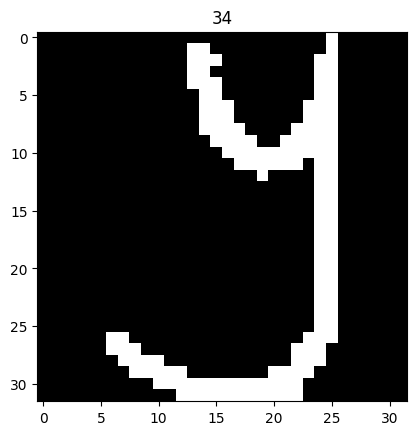

In [ ]:
print(Y_train.shape)
print(X_train.shape)
index = 7
plt.title((Y_train[index]))
plt.imshow(X_train[index].reshape(32, 32), cmap=cm.binary)

In [15]:
import tensorflow as tf

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(32, 32)),
  tf.keras.layers.Dense(1024, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(89, activation='softmax')
])

model.compile(optimizer='SGD',
  loss='categorical_crossentropy',
  metrics=['accuracy'])

model.fit(X_train, Y_train_ohe, epochs=15, batch_size=100)
model.evaluate(X_test, Y_test_ohe)

/Users/31_grudnia/Desktop/Python/Playground/Masters_Degree_Project/backend/venv/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
4466/4466 ━━━━━━━━━━━━━━━━━━━━ 38s 8ms/step - accuracy: 0.1843 - loss: 3.4712
Epoch 2/15
4466/4466 ━━━━━━━━━━━━━━━━━━━━ 38s 9ms/step - accuracy: 0.5182 - loss: 1.7060
Epoch 3/15
4466/4466 ━━━━━━━━━━━━━━━━━━━━ 37s 8ms/step - accuracy: 0.5816 - loss: 1.4429
Epoch 4/15
4466/4466 ━━━━━━━━━━━━━━━━━━━━ 35s 8ms/step - accuracy: 0.6151 - loss: 1.2933
Epoch 5/15
4466/4466 ━━━━━━━━━━━━━━━━━━━━ 36s 8ms/step - accuracy: 0.6437 - loss: 1.1859
Epoch 6/15
4466/4466 ━━━━━━━━━━━━━━━━━━━━ 38s 8ms/step - accuracy: 0.6607 - loss: 1.1101
Epoch 7/15
4466/4466 ━━━━━━━━━━━━━━━━━━━━ 39s 9ms/step - accuracy: 0.6747 - loss: 1.0541
Epoch 8/15
4466/4466 ━━━━━━━━━━━━━━━━━━━━ 43s 10ms/step - accuracy: 0.6853 - loss: 1.0076
Epoch 9/15
4466/4466 ━━━━━━━━━━━━━━━━━━━━ 40s 9ms/step - accuracy: 0.6953 - loss: 0.9689
Epoch 10/15
4466/4466 ━━━━━━━━━━━━━━━━━━━━ 42s 9ms/step - accuracy: 0.7030 - loss: 0.9389
Epoch 11/15
4466/4466 ━━━━━━━━━━━━━━━━━━━━ 42s 9ms/step - accuracy: 0.7099 - loss: 0.9089
Epoch 12/15
4466/4

[0.7159880995750427, 0.7611215710639954]

In [18]:
predictions = model.predict(X_val)
predicted_class_indices = np.argmax(predictions, axis=1)


1745/1745 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


In [23]:
all_chars = 500
true_labels = 0
for i in range(all_chars):
    print(f"Index: {i}; Prediction: {predicted_class_indices[i]}; True Label: {Y_val[i]}")
    if predicted_class_indices[i] == Y_val[i]:
        true_labels += 1
print(f"Accuracy on valid set: {(true_labels/all_chars) * 100}%")



Index: 0; Prediction: 79; True Label: 79
Index: 1; Prediction: 84; True Label: 84
Index: 2; Prediction: 38; True Label: 12
Index: 3; Prediction: 11; True Label: 11
Index: 4; Prediction: 36; True Label: 36
Index: 5; Prediction: 61; True Label: 2
Index: 6; Prediction: 26; True Label: 26
Index: 7; Prediction: 44; True Label: 44
Index: 8; Prediction: 11; True Label: 11
Index: 9; Prediction: 49; True Label: 49
Index: 10; Prediction: 68; True Label: 68
Index: 11; Prediction: 54; True Label: 28
Index: 12; Prediction: 43; True Label: 43
Index: 13; Prediction: 15; True Label: 15
Index: 14; Prediction: 14; True Label: 14
Index: 15; Prediction: 44; True Label: 1
Index: 16; Prediction: 68; True Label: 68
Index: 17; Prediction: 3; True Label: 9
Index: 18; Prediction: 59; True Label: 59
Index: 19; Prediction: 86; True Label: 86
Index: 20; Prediction: 13; True Label: 13
Index: 21; Prediction: 48; True Label: 48
Index: 22; Prediction: 78; True Label: 78
Index: 23; Prediction: 76; True Label: 76
Index: